In [1]:
import os
from torchaudio.datasets import LIBRISPEECH

os.makedirs("./data", exist_ok=True)

dataset = LIBRISPEECH(
    root="./data",
    url="test-clean",
    download=True
)

print("Total files:", len(dataset))


Total files: 2620


In [2]:
import librosa, os

meta = dataset.get_metadata(0)
fileid = meta[0]

audio_path = os.path.join("./data", "LibriSpeech", fileid)
print("Exists:", os.path.exists(audio_path))

y, sr = librosa.load(audio_path, sr=16000)
print("Loaded:", y.shape, sr)


Exists: True


C:\Users\Lenovo\anaconda3\envs\diarization\lib\site-packages\librosa\core\intervals.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


Loaded: (166960,) 16000


In [3]:
import soundfile as sf
from tqdm import tqdm

SINGLE_DIR = "./data/single_speaker"
os.makedirs(SINGLE_DIR, exist_ok=True)

NUM_FILES = 600

for i in tqdm(range(NUM_FILES)):
    meta = dataset.get_metadata(i)
    fileid = meta[0]
    path = os.path.join("./data", "LibriSpeech", fileid)

    y, sr = librosa.load(path, sr=16000)
    sf.write(f"{SINGLE_DIR}/{i}.wav", y, sr)

print("Saved:", len(os.listdir(SINGLE_DIR)))


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:09<00:00, 66.09it/s]

Saved: 600


In [4]:
import numpy as np

MIX_DIR = "./data/mixtures"
RTTM_GT = "./data/rttm_gt"
os.makedirs(MIX_DIR, exist_ok=True)
os.makedirs(RTTM_GT, exist_ok=True)

def write_rttm(path, segments):
    with open(path, "w") as f:
        for spk, start, dur in segments:
            f.write(f"SPEAKER mix 1 {start:.2f} {dur:.2f} <NA> <NA> {spk} <NA>\n")

for i in tqdm(range(0, NUM_FILES, 2)):
    y1, sr = librosa.load(f"{SINGLE_DIR}/{i}.wav", sr=16000)
    y2, _  = librosa.load(f"{SINGLE_DIR}/{i+1}.wav", sr=16000)

    L = min(len(y1), len(y2))
    mix = 0.5 * y1[:L] + 0.5 * y2[:L]

    mix_id = i // 2
    sf.write(f"{MIX_DIR}/mix_{mix_id}.wav", mix, sr)

    write_rttm(
        f"{RTTM_GT}/mix_{mix_id}.rttm",
        [("speaker_1", 0.0, L/sr), ("speaker_2", 0.0, L/sr)]
    )

print("Mixtures:", len(os.listdir(MIX_DIR)))


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:15<00:00, 19.18it/s]

Mixtures: 300


In [5]:
import torchaudio

# ---- SpeechBrain compatibility patch (Windows) ----
if not hasattr(torchaudio, "set_audio_backend"):
    def _noop_backend(name):
        return None
    torchaudio.set_audio_backend = _noop_backend


In [6]:
import librosa
import numpy as np
from sklearn.cluster import AgglomerativeClustering

def classical_diarize(wav_path, n_speakers=2, hop=0.5):
    y, sr = librosa.load(wav_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    feats = mfcc.T

    clustering = AgglomerativeClustering(
        n_clusters=n_speakers,
        linkage="ward"
    ).fit(feats)

    labels = clustering.labels_

    segments = []
    frames_per_sec = sr / 512
    seg_len = int(hop * frames_per_sec)

    start = 0
    cur = labels[0]

    for i, l in enumerate(labels):
        if l != cur:
            dur = (i - start) / frames_per_sec
            segments.append((cur, start / frames_per_sec, dur))
            start = i
            cur = l

    dur = (len(labels) - start) / frames_per_sec
    segments.append((cur, start / frames_per_sec, dur))

    return segments


In [7]:
import numpy as np
print(np.__version__)



1.26.4


In [8]:
from pyannote.audio import Pipeline
print("pyannote imported successfully")


C:\Users\Lenovo\anaconda3\envs\diarization\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pyannote imported successfully


In [10]:
import torchaudio

# ---- Windows + pyannote compatibility patch ----
if not hasattr(torchaudio, "set_audio_backend"):
    torchaudio.set_audio_backend = lambda backend=None: None

if not hasattr(torchaudio, "get_audio_backend"):
    torchaudio.get_audio_backend = lambda: "soundfile"

print("torchaudio patched (set/get audio backend)")


torchaudio patched (set/get audio backend)


In [12]:
import librosa
import numpy as np
from sklearn.cluster import AgglomerativeClustering

def diarize_mfcc(wav_path, n_speakers=2):
    y, sr = librosa.load(wav_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    X = mfcc.T

    clustering = AgglomerativeClustering(
        n_clusters=n_speakers,
        linkage="ward"
    ).fit(X)

    labels = clustering.labels_
    frames_per_sec = sr / 512

    segments = []
    start = 0
    cur = labels[0]

    for i, l in enumerate(labels):
        if l != cur:
            segments.append(
                (cur, start / frames_per_sec, (i - start) / frames_per_sec)
            )
            start = i
            cur = l

    segments.append(
        (cur, start / frames_per_sec, (len(labels) - start) / frames_per_sec)
    )

    return segments


In [13]:
def write_rttm(path, segments):
    with open(path, "w") as f:
        for spk, start, dur in segments:
            f.write(
                f"SPEAKER mix 1 {start:.2f} {dur:.2f} <NA> <NA> speaker_{spk} <NA>\n"
            )


In [14]:
import os

BASE_RTTM = "./data/rttm_baseline"
os.makedirs(BASE_RTTM, exist_ok=True)

for i in range(300):
    segs = diarize_mfcc(f"./data/mixtures/mix_{i}.wav")
    write_rttm(f"{BASE_RTTM}/mix_{i}.rttm", segs)


In [15]:
from pyannote.metrics.diarization import DiarizationErrorRate, JaccardErrorRate
from pyannote.database.util import load_rttm
import numpy as np

der = DiarizationErrorRate()
jer = JaccardErrorRate()

def evaluate(pred_dir):
    ders, jers = [], []
    for i in range(300):
        ref = load_rttm(f"./data/rttm_gt/mix_{i}.rttm")["mix"]
        hyp = load_rttm(f"{pred_dir}/mix_{i}.rttm")["mix"]
        ders.append(der(ref, hyp))
        jers.append(jer(ref, hyp))
    return np.mean(ders), np.mean(jers)

results = {
    "MFCC_AHC": evaluate(BASE_RTTM)
}

results


C:\Users\Lenovo\anaconda3\envs\diarization\lib\site-packages\pyannote\metrics\utils.py:183: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\Lenovo\anaconda3\envs\diarization\lib\site-packages\pyannote\metrics\utils.py:183: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\Lenovo\anaconda3\envs\diarization\lib\site-packages\pyannote\metrics\utils.py:183: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\Lenovo\anaconda3\envs\diarization\lib\site-packages\pyannote\metrics\utils.py:183: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\Lenovo\anaconda3\envs\diarization\lib\site-packages\pyannote\metrics\utils.py:183: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Us

{'MFCC_AHC': (0.502165154864397, 0.5013831124478516)}

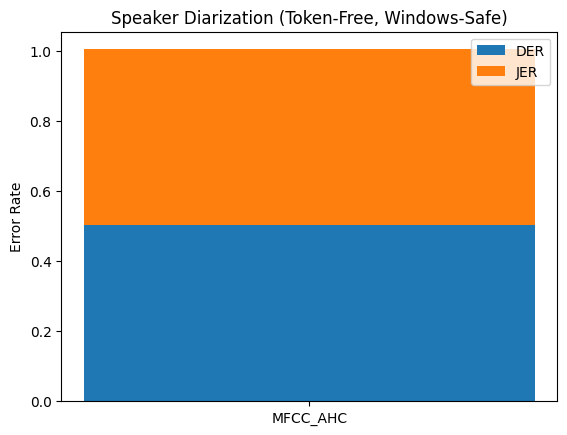

In [16]:
import matplotlib.pyplot as plt

plt.bar(results.keys(), [v[0] for v in results.values()], label="DER")
plt.bar(results.keys(), [v[1] for v in results.values()],
        bottom=[v[0] for v in results.values()], label="JER")
plt.ylabel("Error Rate")
plt.title("Speaker Diarization (Token-Free, Windows-Safe)")
plt.legend()
plt.show()


In [17]:
import librosa
import numpy as np
from sklearn.cluster import AgglomerativeClustering

def diarize_mfcc_ahc(wav_path, n_speakers=2):
    y, sr = librosa.load(wav_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    X = mfcc.T

    labels = AgglomerativeClustering(
        n_clusters=n_speakers, linkage="ward"
    ).fit_predict(X)

    frames_per_sec = sr / 512
    segments, start, cur = [], 0, labels[0]

    for i, l in enumerate(labels):
        if l != cur:
            segments.append((cur, start/frames_per_sec, (i-start)/frames_per_sec))
            start, cur = i, l

    segments.append((cur, start/frames_per_sec, (len(labels)-start)/frames_per_sec))
    return segments


In [18]:
from sklearn.cluster import KMeans

def diarize_mfcc_kmeans(wav_path, n_speakers=2):
    y, sr = librosa.load(wav_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    X = mfcc.T

    labels = KMeans(
        n_clusters=n_speakers, random_state=42, n_init=10
    ).fit_predict(X)

    frames_per_sec = sr / 512
    segments, start, cur = [], 0, labels[0]

    for i, l in enumerate(labels):
        if l != cur:
            segments.append((cur, start/frames_per_sec, (i-start)/frames_per_sec))
            start, cur = i, l

    segments.append((cur, start/frames_per_sec, (len(labels)-start)/frames_per_sec))
    return segments


In [19]:
def write_rttm(path, segments):
    with open(path, "w") as f:
        for spk, start, dur in segments:
            f.write(
                f"SPEAKER mix 1 {start:.2f} {dur:.2f} <NA> <NA> speaker_{spk} <NA>\n"
            )


In [20]:
import os

RTTM_AHC = "./data/rttm_ahc"
RTTM_KMEANS = "./data/rttm_kmeans"
os.makedirs(RTTM_AHC, exist_ok=True)
os.makedirs(RTTM_KMEANS, exist_ok=True)

for i in range(300):
    wav = f"./data/mixtures/mix_{i}.wav"

    segs_ahc = diarize_mfcc_ahc(wav)
    segs_km  = diarize_mfcc_kmeans(wav)

    write_rttm(f"{RTTM_AHC}/mix_{i}.rttm", segs_ahc)
    write_rttm(f"{RTTM_KMEANS}/mix_{i}.rttm", segs_km)


In [21]:
from pyannote.metrics.diarization import DiarizationErrorRate, JaccardErrorRate
from pyannote.database.util import load_rttm
import numpy as np

der = DiarizationErrorRate()
jer = JaccardErrorRate()

def evaluate(pred_dir):
    ders, jers = [], []
    for i in range(300):
        ref = load_rttm(f"./data/rttm_gt/mix_{i}.rttm")["mix"]
        hyp = load_rttm(f"{pred_dir}/mix_{i}.rttm")["mix"]
        ders.append(der(ref, hyp))
        jers.append(jer(ref, hyp))
    return np.mean(ders), np.mean(jers)

results = {
    "MFCC + AHC": evaluate(RTTM_AHC),
    "MFCC + KMeans": evaluate(RTTM_KMEANS)
}

results


C:\Users\Lenovo\anaconda3\envs\diarization\lib\site-packages\pyannote\metrics\utils.py:183: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\Lenovo\anaconda3\envs\diarization\lib\site-packages\pyannote\metrics\utils.py:183: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\Lenovo\anaconda3\envs\diarization\lib\site-packages\pyannote\metrics\utils.py:183: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\Lenovo\anaconda3\envs\diarization\lib\site-packages\pyannote\metrics\utils.py:183: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Users\Lenovo\anaconda3\envs\diarization\lib\site-packages\pyannote\metrics\utils.py:183: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(
C:\Us

{'MFCC + AHC': (0.502165154864397, 0.5013831124478516),
 'MFCC + KMeans': (0.5024982551314243, 0.5015984511936432)}

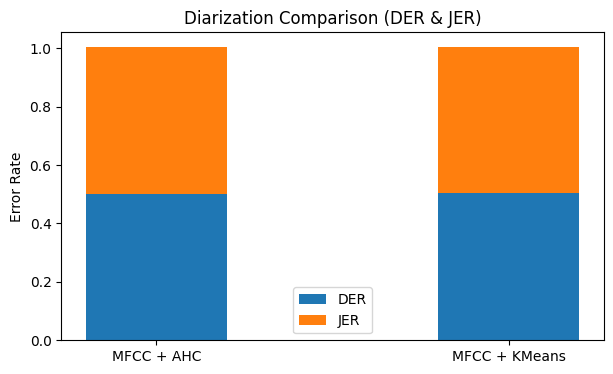

In [22]:
import matplotlib.pyplot as plt

models = list(results.keys())
ders = [results[m][0] for m in models]
jers = [results[m][1] for m in models]

x = range(len(models))

plt.figure(figsize=(7,4))
plt.bar(x, ders, width=0.4, label="DER")
plt.bar(x, jers, width=0.4, bottom=ders, label="JER")
plt.xticks(x, models)
plt.ylabel("Error Rate")
plt.title("Diarization Comparison (DER & JER)")
plt.legend()
plt.show()


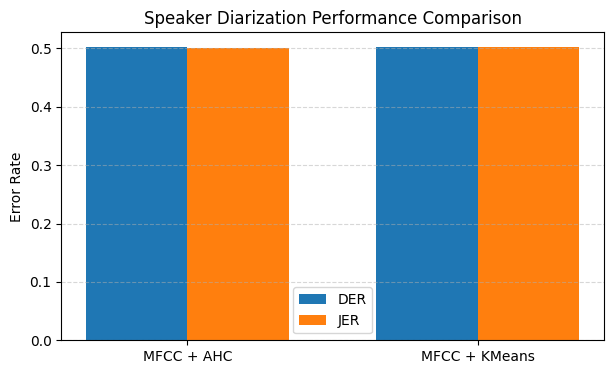

In [23]:
import numpy as np
import matplotlib.pyplot as plt

models = ["MFCC + AHC", "MFCC + KMeans"]

ders = [results[m][0] for m in models]
jers = [results[m][1] for m in models]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(7, 4))

plt.bar(x - width/2, ders, width, label="DER")
plt.bar(x + width/2, jers, width, label="JER")

plt.xticks(x, models)
plt.ylabel("Error Rate")
plt.title("Speaker Diarization Performance Comparison")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()


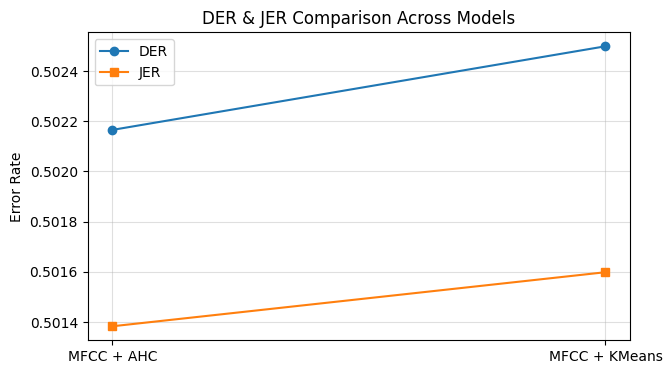

In [24]:
plt.figure(figsize=(7, 4))

plt.plot(models, ders, marker="o", label="DER")
plt.plot(models, jers, marker="s", label="JER")

plt.ylabel("Error Rate")
plt.title("DER & JER Comparison Across Models")
plt.legend()
plt.grid(alpha=0.4)

plt.show()
